## CPE-695 Forest Fire Prediction and Analysis

### Discription of Dataset

X - x-axis spatial coordinate within the Montesinho park map: 1 to 9

Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9

month - month of the year: 'jan' to 'dec'

day - day of the week: 'mon' to 'sun'

FFMC - FFMC index from the FWI system: 18.7 to 96.20

DMC - DMC index from the FWI system: 1.1 to 291.3

DC - DC index from the FWI system: 7.9 to 860.6

ISI - ISI index from the FWI system: 0.0 to 56.10

temp - temperature in Celsius degrees: 2.2 to 33.30

RH - relative humidity in %: 15.0 to 100

wind - wind speed in km/h: 0.40 to 9.40

rain - outside rain in mm/m2 : 0.0 to 6.4

area - the burned area of the forest (in ha): 0.00 to 1090.84

(this output variable is very skewed towards 0.0, thus it may make
sense to model with the logarithm transform).

The Fine Fuel Moisture Code (FFMC) represents fuel moisture of forest litter fuels under the shade of a forest 
canopy. It is intended to represent moisture conditions for shaded litter fuels, the equivalent of 16-hour time lag. 
It ranges from 0-101. Subtracting the FFMC value from 100 can provide an estimate for the equivalent 
(approximately 10h) fuel moisture content, most accurate when FFMC values are roughly above 80

Fuel moisture is a measure of the amount of water in a fuel (vegetation) available to a fire, and is expressed as a percent of the dry weight of that specific fuel. For example, if a fuel were totally dry, the fuel moisture content would be zero percent.

The Drought Code (DC), much like the Keetch-Byrum Drought Index, represents drying deep into the soil. It approximates moisture conditions for the equivalent of 53-day (1272 hour) time-lag fuels. It is unitless, with a maximum value of 1000. Extreme drought conditions have produced DC values near 800.

The Initial Spread Index (ISI) is analogous to the NFDRS Spread Component (SC). It integrates fuel moisture for fine dead fuels and surface windspeed to estimate a spread potential. ISI is a key input for fire behavior predictions in the FBP system. It is unitless and open ended.

### Importing necessary libraries

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

In [50]:
%matplotlib inline

In [51]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

### Data Visualization

In [52]:
df = pd.read_csv("forestfires.csv")
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [54]:
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


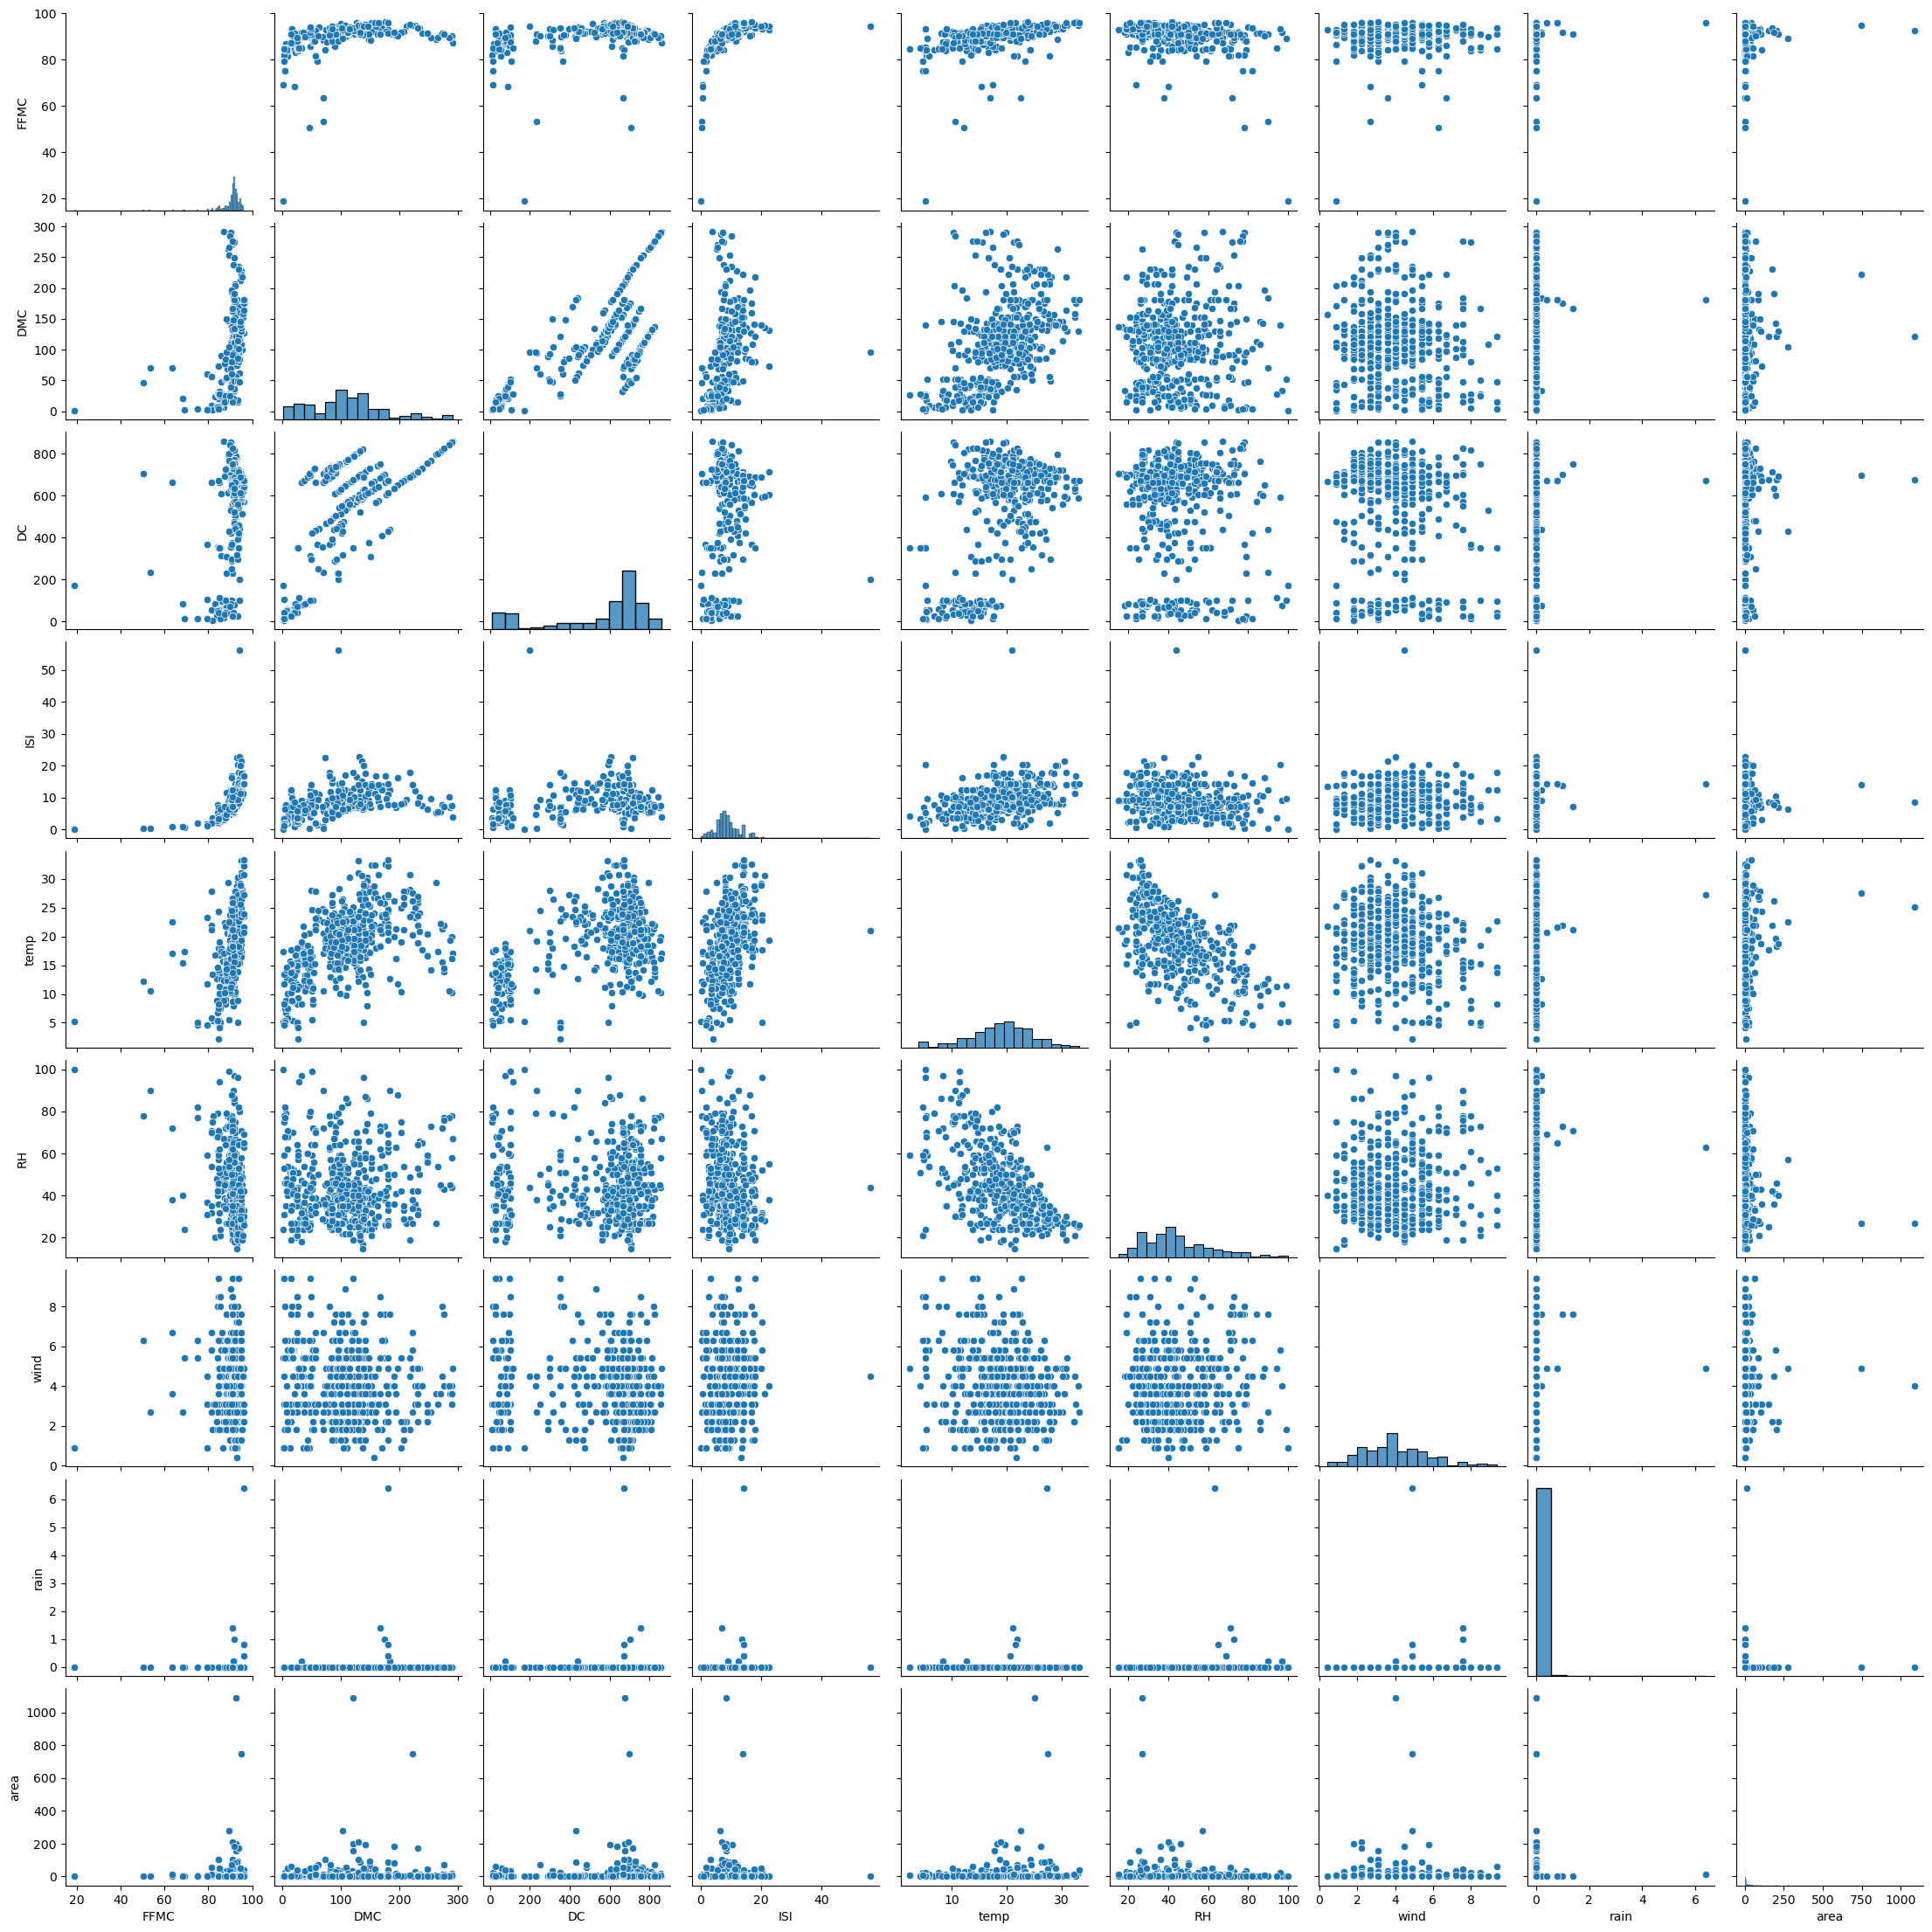

In [55]:
sns.pairplot(df, vars=["FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain", "area"])
plt.show()

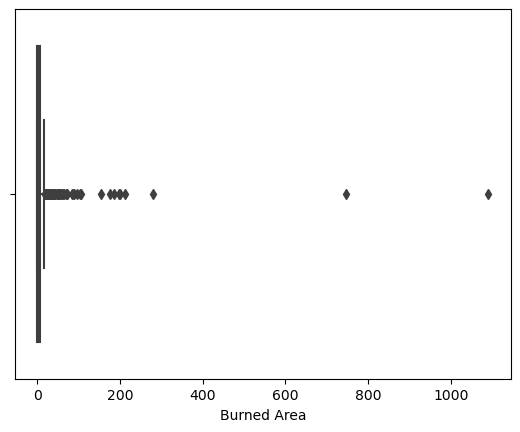

In [56]:
sns.boxplot(x=df["area"])
plt.xlabel("Burned Area")
plt.show()

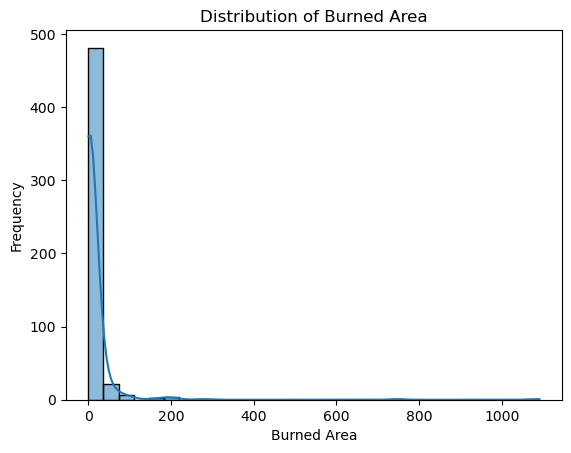

In [57]:
sns.histplot(df["area"], bins=30, kde=True)
plt.xlabel("Burned Area")
plt.ylabel("Frequency")
plt.title("Distribution of Burned Area")
plt.show()

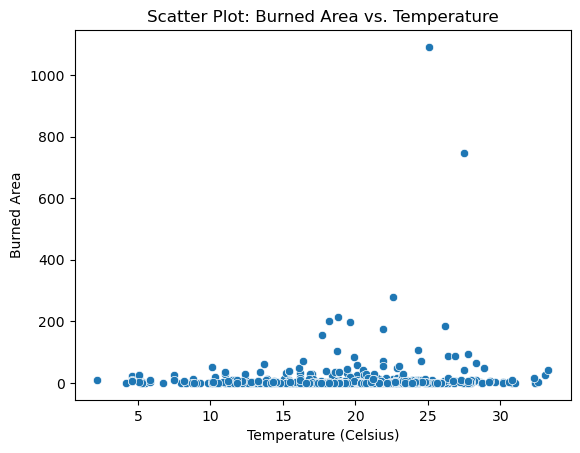

In [58]:
sns.scatterplot(x="temp", y="area", data=df)
plt.xlabel("Temperature (Celsius)")
plt.ylabel("Burned Area")
plt.title("Scatter Plot: Burned Area vs. Temperature")
plt.show()

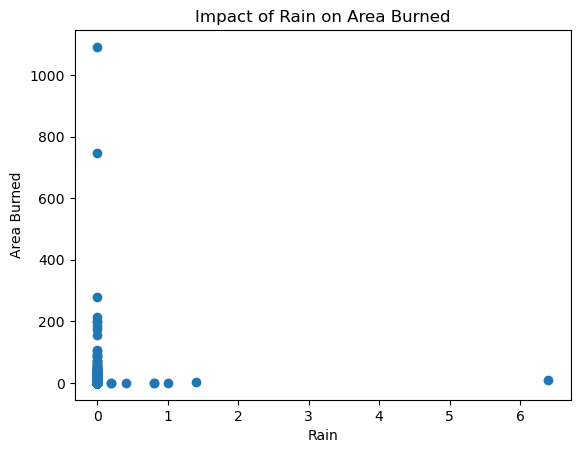

In [59]:
plt.scatter(df['rain'], df['area'])
plt.title('Impact of Rain on Area Burned')
plt.xlabel('Rain')
plt.ylabel('Area Burned')
plt.show()

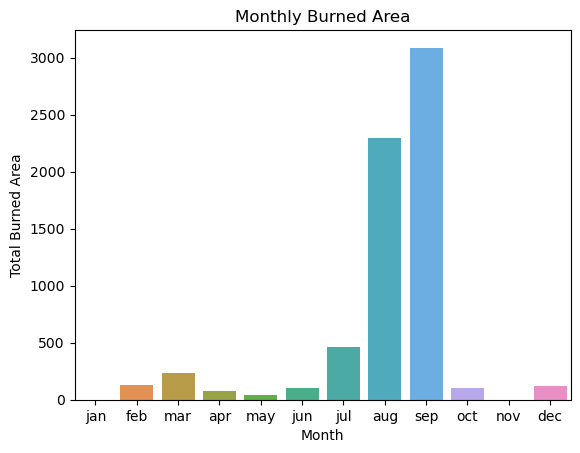

In [60]:
data_monthly = df.groupby("month")["area"].sum().reset_index()
sns.barplot(x="month", y="area", data=data_monthly, order=["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"])
plt.xlabel("Month")
plt.ylabel("Total Burned Area")
plt.title("Monthly Burned Area")
plt.show()

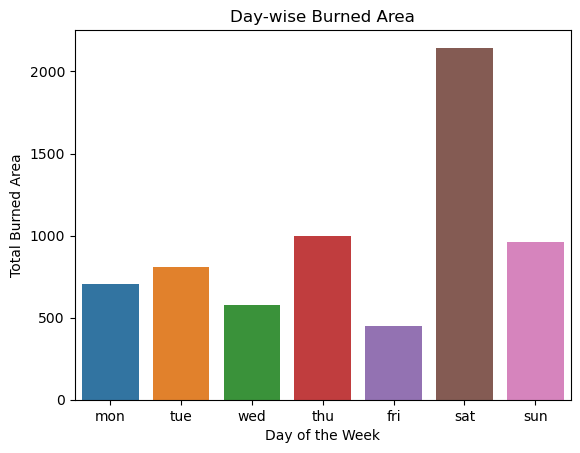

In [61]:
data_daily = df.groupby("day")["area"].sum().reset_index()
sns.barplot(x="day", y="area", data=data_daily, order=["mon", "tue", "wed", "thu", "fri", "sat", "sun"])
plt.xlabel("Day of the Week")
plt.ylabel("Total Burned Area")
plt.title("Day-wise Burned Area")
plt.show()

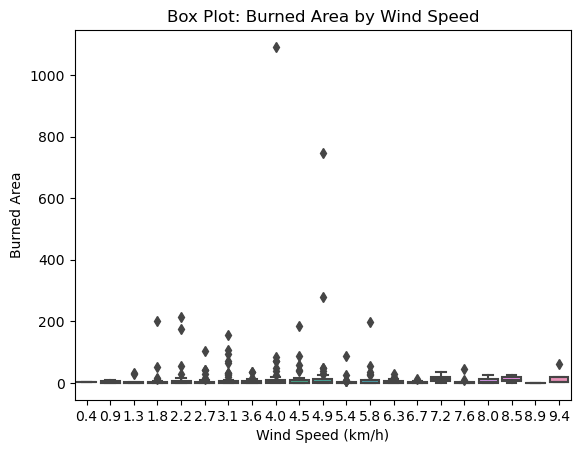

In [62]:
sns.boxplot(x="wind", y="area", data=df)
plt.xlabel("Wind Speed (km/h)")
plt.ylabel("Burned Area")
plt.title("Box Plot: Burned Area by Wind Speed")
plt.show()

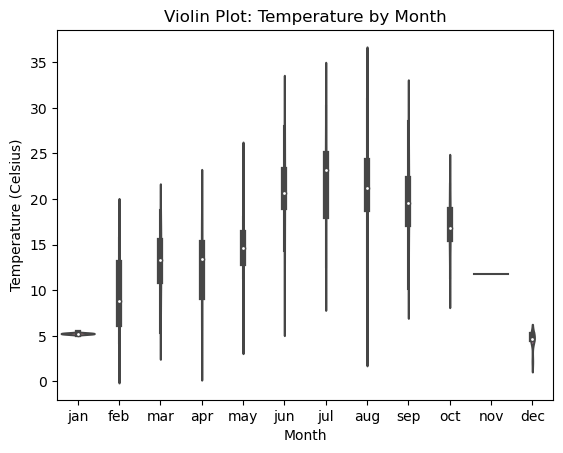

In [63]:
sns.violinplot(x="month", y="temp", data=df, order=["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"])
plt.xlabel("Month")
plt.ylabel("Temperature (Celsius)")
plt.title("Violin Plot: Temperature by Month")
plt.show()

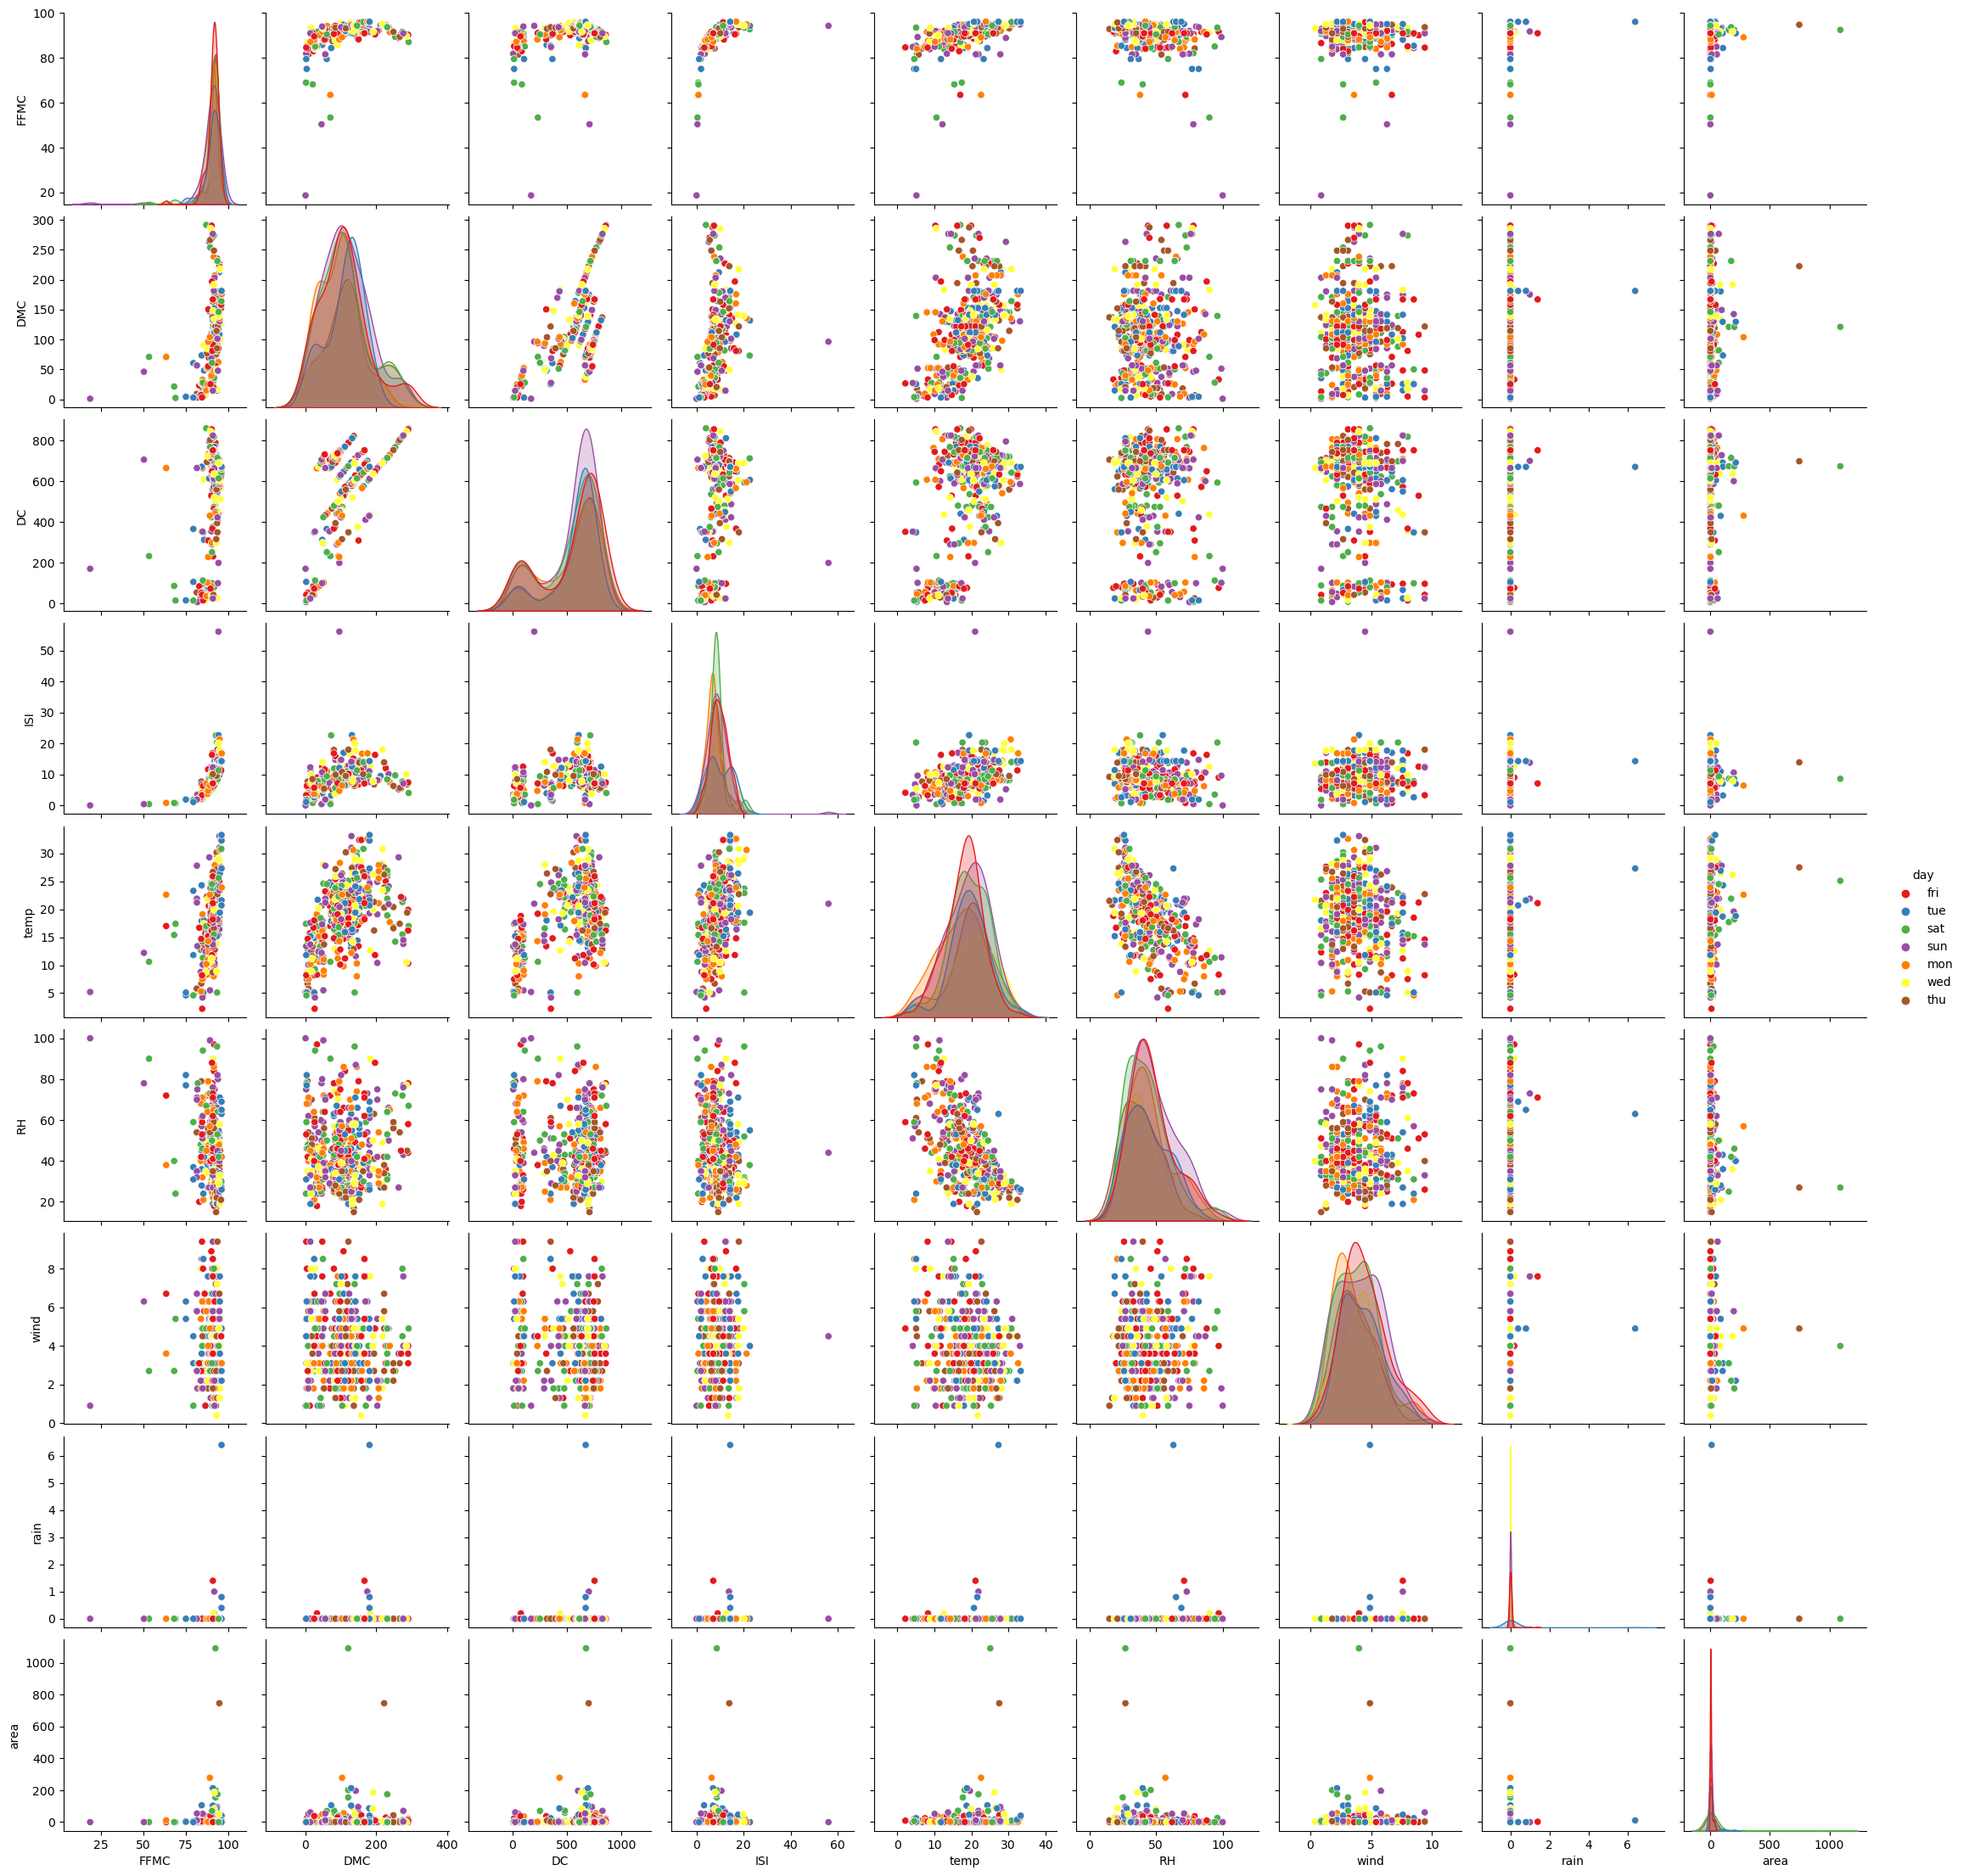

In [64]:
sns.pairplot(df, vars=["FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain", "area"], hue="day", palette="Set1")
plt.show()

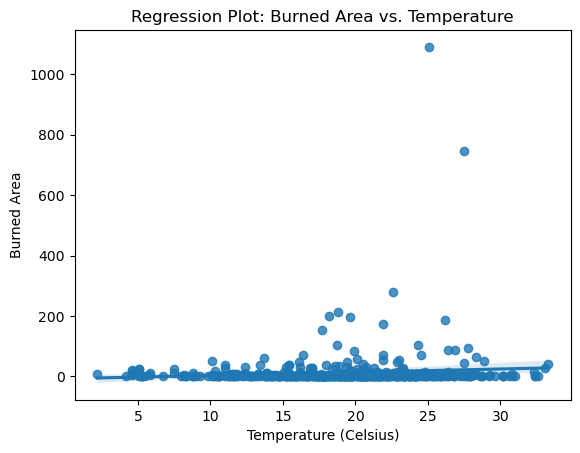

In [65]:
sns.regplot(x="temp", y="area", data=df)
plt.xlabel("Temperature (Celsius)")
plt.ylabel("Burned Area")
plt.title("Regression Plot: Burned Area vs. Temperature")
plt.show()

### Data Preperation

In [66]:
def find_season(month):
    if month in ['sep','oct','nov']:
        return 'fall'
    elif month in ['jun','jul','aug']:
        return 'summer'
    elif month in ['mar','apr','may']:
        return 'spring'
    else:
        return 'winter'

In [67]:
def at_risk(area):
    if area >5:
        return 1
    else:
        return 0

In [68]:
mean=df['area'].mean()
std=df['area'].std()
print('Mean is:',mean)
print('STD is:',std)

Mean is: 12.847292069632493
STD is: 63.65581846794077


In [69]:
season_dict={'month':df['month'],
           'day':df['day'],
           'season':df['month'].apply(find_season)}
season_df=pd.DataFrame(season_dict)
season_columns=['month','day','season']

In [70]:
season_df

,month,day,season
0,mar,fri,spring
1,oct,tue,fall
2,oct,sat,fall
3,mar,fri,spring
4,mar,sun,spring
...,...,...,...
512,aug,sun,summer
513,aug,sun,summer
514,aug,sun,summer
515,aug,sat,summer


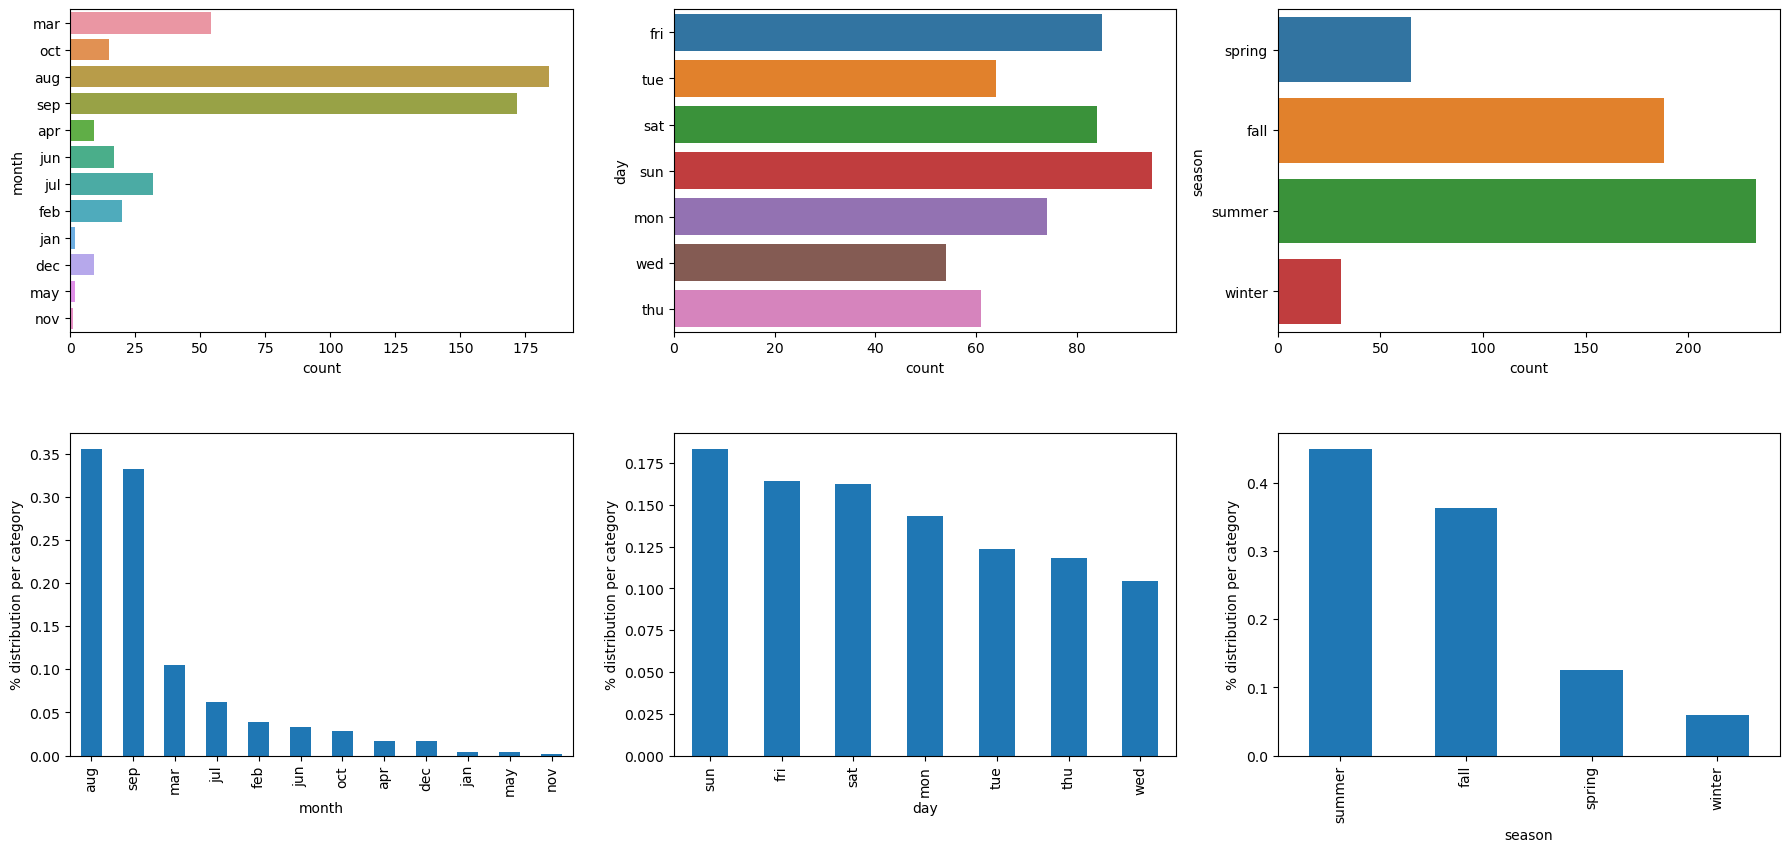

In [71]:
plt.figure(figsize=(18,12))
for i,j in enumerate(season_columns,1):
    plt.subplot(3,3,i)
    sns.countplot(data=season_df,y=j)
    plt.subplot(3,3,i+3)
    season_df[j].value_counts(normalize=True).plot.bar()
    plt.ylabel('% distribution per category')
    plt.xlabel(j)
plt.tight_layout()
plt.show()  

In [72]:
burnt_area=df['area']

pertile=[25, 50, 75, 90, 95]
pertiles_values=np.percentile(burnt_area,pertile)

for i,j in enumerate(pertile):
    print(f"{j}th percentile: {pertiles_values[i]}")

colors=['red','green','blue','purple','orange']

25th percentile: 0.0
50th percentile: 0.52
75th percentile: 6.57
90th percentile: 25.262000000000043
95th percentile: 48.713999999999984


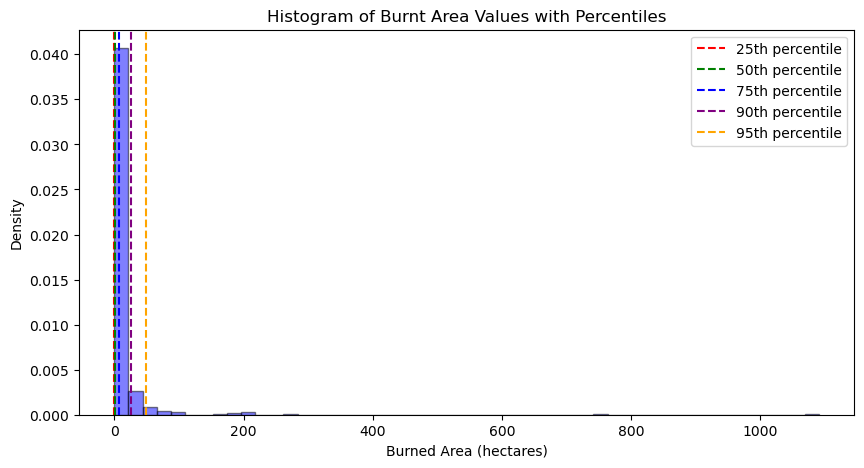

In [73]:
plt.figure(figsize=(10,5))
plt.hist(burnt_area, bins=50, color='blue', edgecolor='black', alpha=0.5, density=True)
for p, value, color in zip(pertile, pertiles_values, colors):
    plt.axvline(value, color=color, linestyle='--', label=f'{p}th percentile')
plt.xlabel('Burned Area (hectares)')
plt.ylabel('Density')
plt.legend()
plt.title('Histogram of Burnt Area Values with Percentiles')
plt.show()

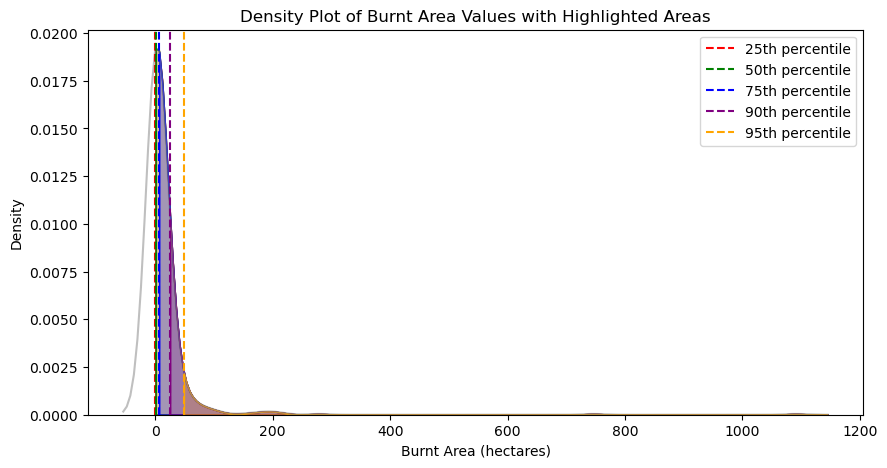

In [74]:
plt.figure(figsize=(10, 5))
sns.kdeplot(burnt_area, fill=False, color='gray', alpha=0.5)

for p, value, color in zip(pertile, pertiles_values, colors):
    plt.axvline(value, color=color, linestyle='--', label=f'{p}th percentile')
    sns.kdeplot(burnt_area, fill=True, clip=(value, np.inf), color=color, alpha=0.2)

plt.xlabel('Burnt Area (hectares)')
plt.ylabel('Density')
plt.legend()
plt.title('Density Plot of Burnt Area Values with Highlighted Areas')
plt.show()

In [75]:
df['high risk']=df['area'].apply(at_risk)
df['season']=df['month'].apply(find_season)


df2=df[['high risk','area','FFMC','DMC','DC','ISI','temp','RH','wind','rain']]
correlation_matrix=df2.corr()

In [76]:
import plotly.subplots as sp


fig=sp.make_subplots(rows=1,cols=1)
heatmap=go.Heatmap(z=correlation_matrix,x=correlation_matrix.columns,y=correlation_matrix.columns,colorscale='RdBu_r', zmin=-1, zmax=1)
fig.add_trace(heatmap)

for i, row in enumerate(correlation_matrix.index):
    for j, col in enumerate(correlation_matrix.columns):
        fig.add_annotation(go.layout.Annotation(text=f"{correlation_matrix.iloc[i, j]:.2f}",x=col,y=row,showarrow=False,font=dict(size=12)))

fig.update_layout(title='Correlation Matrix Heatmap',xaxis_title='Variables',yaxis_title='Variables')
fig.show()

In [77]:
df2.corr()['high risk'].sort_values(ascending=False)

high risk    1.000000
area         0.297696
wind         0.056899
rain         0.045013
DC           0.023488
DMC          0.022469
FFMC         0.005749
temp        -0.003714
ISI         -0.026401
RH          -0.041625
Name: high risk, dtype: float64

In [79]:
def standardize(df, lst):
    for var in lst:
        df[var+'_sd'] = (df[var] - np.mean(df[var])) / np.std(df[var])

In [80]:

area_zero_count = (df['area'] == 0).sum()
area_more_than_zero_count = (df['area'] > 0).sum()


In [81]:
fig1 = go.Figure(go.Bar(x=['Area = 0', 'Area > 0'], y=[area_zero_count, area_more_than_zero_count], marker_color=['blue', 'orange']))

In [82]:
fig1.update_layout(title='Number of Instances with Area Equal to 0 vs. More Than 0', xaxis_title='Area Groups', yaxis_title='Count')


In [83]:
# Count the instances for the second bar graph (5 or greater vs. less than 5)
area_less_than_ten_count = (df['area'] < 10).sum()
area_ten_or_greater_count = (df['area'] >= 10).sum()

In [84]:
fig2 = go.Figure(go.Bar(x=['Area < 10', 'Area >= 10'], y=[area_less_than_ten_count, area_ten_or_greater_count], marker_color=['blue', 'orange']))
fig2.update_layout(title='Number of Instances with Area Less Than 10 vs. 10 or Greater', xaxis_title='Area Groups', yaxis_title='Count')

fig1.show()
fig2.show()

In [85]:
one_hot_encoded = pd.get_dummies(df['season'], prefix='season')
forestfires_encoded = pd.concat([df, one_hot_encoded], axis=1)
forestfires_encoded.drop('season', axis=1, inplace=True)

standardize(forestfires_encoded, ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area'])
forestfires_encoded

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,...,season_winter,FFMC_sd,DMC_sd,DC_sd,ISI_sd,temp_sd,RH_sd,wind_sd,rain_sd,area_sd
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,...,False,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268,-0.202020
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,...,False,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268,-0.202020
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,...,False,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268,-0.202020
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,...,False,0.191362,-1.212361,-1.898266,-0.004756,-1.825402,3.233519,-0.009834,0.603155,-0.202020
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,...,False,-0.243833,-0.931043,-1.798600,0.126966,-1.291012,3.356206,-1.238940,-0.073268,-0.202020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,...,False,-1.640083,-0.846648,0.474768,-1.563460,1.536084,-0.753800,-0.736124,-0.073268,-0.100753
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,...,False,-1.640083,-0.846648,0.474768,-1.563460,0.519019,1.638592,0.995798,-0.073268,0.651674
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,...,False,-1.640083,-0.846648,0.474768,-1.563460,0.398350,1.577248,1.498614,-0.073268,-0.026532
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,...,False,0.680957,0.549003,0.269382,0.500176,1.156839,-0.140366,-0.009834,-0.073268,-0.202020


In [86]:
all_features = ['high risk', 'area', 'FFMC_sd', 'DMC_sd', 'DC_sd', 'ISI_sd', 'temp_sd', 'RH_sd', 'wind_sd', 'rain_sd']
correlation_matrix_all = forestfires_encoded[all_features].corr()

fig_all = ff.create_annotated_heatmap(
    z=correlation_matrix_all.values,
    x=list(correlation_matrix_all.columns),
    y=list(correlation_matrix_all.index),
    colorscale='RdBu_r',
    annotation_text=correlation_matrix_all.round(2).values,
    showscale=True
)

fig_all.update_layout(
    title='Correlation Heatmap of All Forest Fires Features',
    xaxis=dict(title='Features', side='bottom'),
    yaxis=dict(title='Features'),
)

fig_all.show()

In [93]:
forestfires_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   X              517 non-null    int64  
 1   Y              517 non-null    int64  
 2   month          517 non-null    object 
 3   day            517 non-null    object 
 4   FFMC           517 non-null    float64
 5   DMC            517 non-null    float64
 6   DC             517 non-null    float64
 7   ISI            517 non-null    float64
 8   temp           517 non-null    float64
 9   RH             517 non-null    int64  
 10  wind           517 non-null    float64
 11  rain           517 non-null    float64
 12  area           517 non-null    float64
 13  high risk      517 non-null    int64  
 14  season_fall    517 non-null    bool   
 15  season_spring  517 non-null    bool   
 16  season_summer  517 non-null    bool   
 17  season_winter  517 non-null    bool   
 18  FFMC_sd   

In [94]:
forestfires_encoded = pd.get_dummies(df,columns=['day','month','season'],drop_first=True)

### ML #1 Neural Network

In [95]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Assuming you have a DataFrame named 'df' with your dataset
# If not, you can load your dataset using pd.read_csv or other methods

# Sample preprocessing steps, replace with your actual DataFrame
# Convert boolean columns to integers
bool_columns = ['day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed',
                'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
                'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
                'month_sep', 'season_spring', 'season_summer', 'season_winter']

forestfires_encoded[bool_columns] = forestfires_encoded[bool_columns].astype(int)

# Split the data into features and target
X = forestfires_encoded.drop(['high risk'], axis=1)  # Features
y = forestfires_encoded['high risk']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (optional but often recommended for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model using tf.keras
model = Sequential([
    Dense(8, input_dim=X_train.shape[1], activation='relu'),
    Dense(1, activation='sigmoid')  # for binary classification, use 'sigmoid'
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=1)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Test accuracy: {accuracy}')

# Now you can use classification_report
from sklearn.metrics import classification_report
print('Classification Report:')
print(classification_report(y_test, y_pred_binary))



Epoch 1/50


413/413 [==============================] - 1s 1ms/step - loss: 0.7715 - accuracy: 0.5157
Epoch 2/50
413/413 [==============================] - 0s 889us/step - loss: 0.6162 - accuracy: 0.6998
Epoch 3/50
413/413 [==============================] - 0s 870us/step - loss: 0.5549 - accuracy: 0.7482
Epoch 4/50
413/413 [==============================] - 0s 832us/step - loss: 0.5189 - accuracy: 0.7627
Epoch 5/50
413/413 [==============================] - 0s 802us/step - loss: 0.4872 - accuracy: 0.7651
Epoch 6/50
413/413 [==============================] - 0s 911us/step - loss: 0.4567 - accuracy: 0.7893
Epoch 7/50
413/413 [==============================] - 0s 882us/step - loss: 0.4265 - accuracy: 0.8160
Epoch 8/50
413/413 [==============================] - 0s 880us/step - loss: 0.3972 - accuracy: 0.8354
Epoch 9/50
413/413 [==============================] - 0s 934us/step - loss: 0.3692 - accuracy: 0.8523
Epoch 10/50
413/413 [==============================] - 0s 882us/step - loss: 0.3

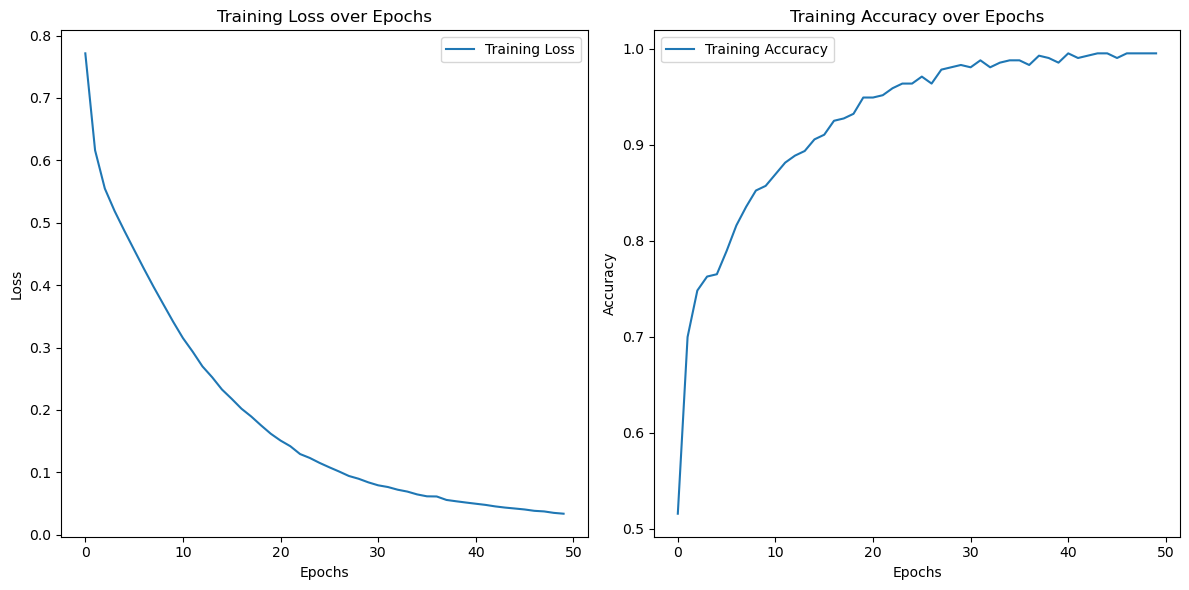

In [96]:
# Plot training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### ML #2 K-Nearest Neighbour

Best Accuracy: 0.8461538461538461 with n_neighbors=2


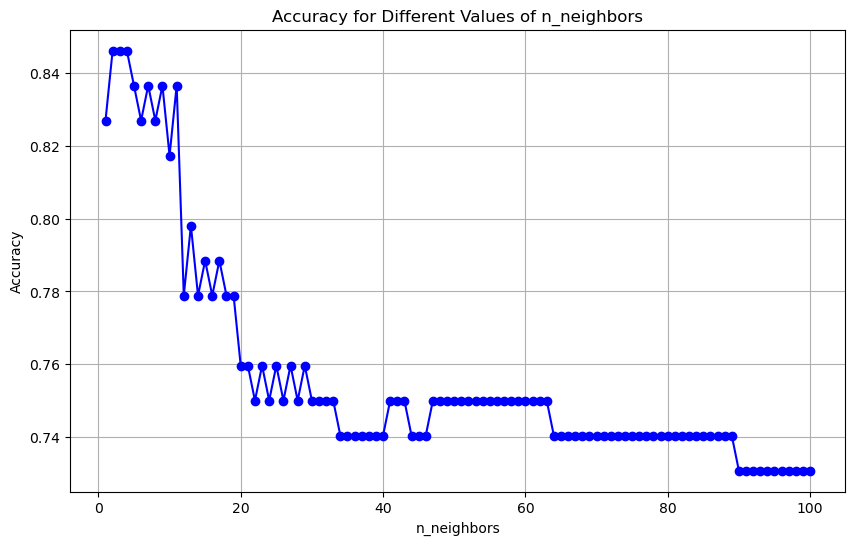

Best Accuracy: 0.8461538461538461 with n_neighbors=2


In [97]:
# Assuming your dataframe is named 'df'
X = forestfires_encoded.drop('high risk', axis=1).values  # Convert to NumPy array
y = forestfires_encoded['high risk'].values  # Convert to NumPy array

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

accuracy_values = []
best_accuracy = 0
best_n_neighbors = 0

# Iterate through different values of n_neighbors
for n_neighbors in range(1, 101):
    # Initialize the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Train the model
    knn.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = knn.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    
    accuracy_values.append(accuracy)
    
    # Check if the current model is the best one
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_neighbors = n_neighbors

# Print the best result
print(f'Best Accuracy: {best_accuracy} with n_neighbors={best_n_neighbors}')

# Plot the accuracy values
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), accuracy_values, marker='o', linestyle='-', color='b')
plt.title('Accuracy for Different Values of n_neighbors')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Print the best result
print(f'Best Accuracy: {best_accuracy} with n_neighbors={best_n_neighbors}')

### ML #3 Random Forest

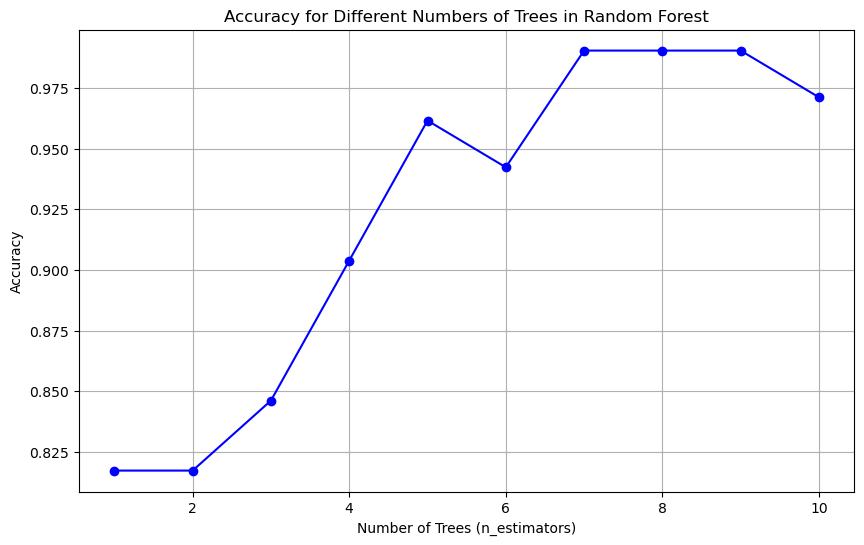

Classification Report - Random Forest:
Best Accuracy: 0.9903846153846154 with n_estimators=7
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        74
           1       1.00      0.90      0.95        30

    accuracy                           0.97       104
   macro avg       0.98      0.95      0.96       104
weighted avg       0.97      0.97      0.97       104

Confusion Matrix:
[[74  0]
 [ 3 27]]


In [98]:
# Assuming your dataframe is named 'df'
X = forestfires_encoded.drop('high risk', axis=1).values  # Convert to NumPy array
y = forestfires_encoded['high risk'].values  # Convert to NumPy array

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Store accuracy values for different numbers of trees
accuracy_values = []

best_accuracy = 0
best_n_estimators = 0

# Iterate through different values of n_estimators
for n_estimators in range(1, 11):
    # Initialize the Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    
    # Train the model
    rf_classifier.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = rf_classifier.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append the accuracy to the list
    accuracy_values.append(accuracy)
    
    # Check if the current model is the best one
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_estimators = n_estimators

# Plot the accuracy values
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), accuracy_values, marker='o', linestyle='-', color='b')
plt.title('Accuracy for Different Numbers of Trees in Random Forest')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

print('Classification Report - Random Forest:')

# Print the best result
print(f'Best Accuracy: {best_accuracy} with n_estimators={best_n_estimators}')

# Display other metrics
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

### Comparison #1 Plotting 'Receiving Operating Characteristic' Curve

Neural Network Accuracy: 0.97
KNN Accuracy: 0.81
Random Forest Accuracy: 1.00


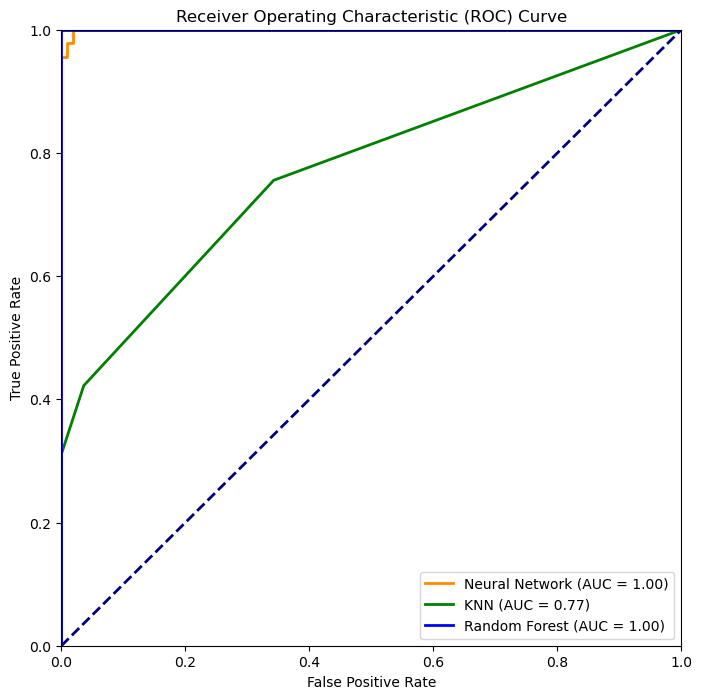

In [99]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Assuming your dataframe is named 'df'
X = forestfires_encoded.drop('high risk', axis=1).values  # Convert to NumPy array
y = forestfires_encoded['high risk'].values  # Convert to NumPy array

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# One-hot encode the target variable for Neural Network
y_train_one_hot = label_binarize(y_train, classes=[0, 1])
y_test_one_hot = label_binarize(y_test, classes=[0, 1])

# Neural Network
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train_one_hot)
y_pred_mlp = mlp.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
y_score_mlp = mlp.predict_proba(X_test)[:, 1]
fpr_mlp, tpr_mlp, _ = roc_curve(y_test_one_hot, y_score_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)  # You can change the value of n_neighbors
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
y_score_knn = knn.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_score_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Random Forest
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
y_score_rf = random_forest.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Print accuracies
print(f'Neural Network Accuracy: {accuracy_mlp:.2f}')
print(f'KNN Accuracy: {accuracy_knn:.2f}')
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')

# Plotting
plt.figure(figsize=(8, 8))

plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label=f'Neural Network (AUC = {roc_auc_mlp:.2f})')
plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label=f'KNN (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [100]:
# Print classification reports
print('\nClassification Report - Neural Network:')
print(classification_report(y_test, y_pred_mlp))

print('\nClassification Report - KNN:')
print(classification_report(y_test, y_pred_knn))

print('\nClassification Report - Random Forest:')
print(classification_report(y_test, y_pred_rf))


Classification Report - Neural Network:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       111
           1       1.00      0.91      0.95        45

    accuracy                           0.97       156
   macro avg       0.98      0.96      0.97       156
weighted avg       0.98      0.97      0.97       156


Classification Report - KNN:
              precision    recall  f1-score   support

           0       0.80      0.96      0.88       111
           1       0.83      0.42      0.56        45

    accuracy                           0.81       156
   macro avg       0.82      0.69      0.72       156
weighted avg       0.81      0.81      0.79       156


Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       111
           1       1.00      1.00      1.00        45

    accuracy                           1.00       156
   macro avg     

### Comparison #2 Confution Matrix

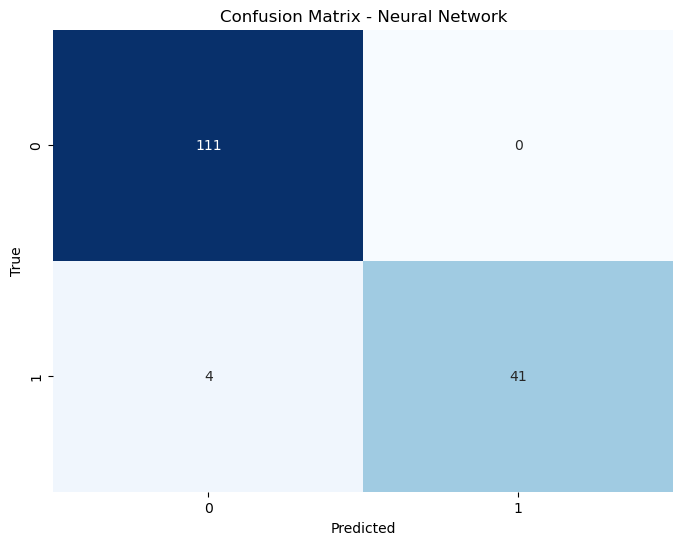

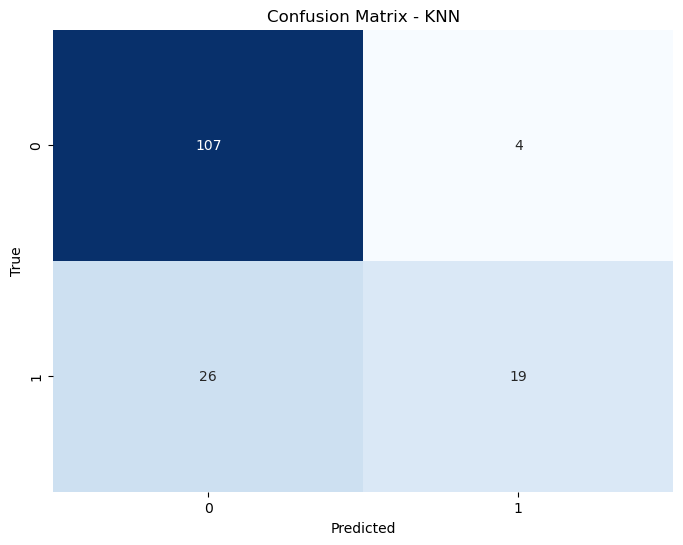

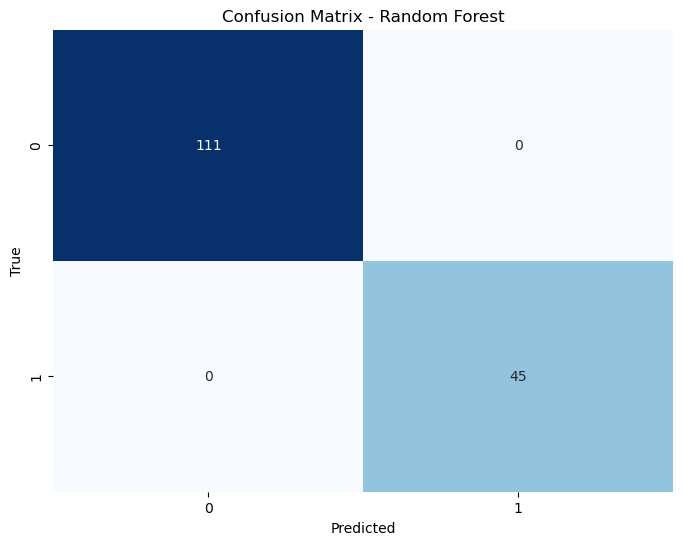

In [101]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_test, y_pred_mlp, 'Confusion Matrix - Neural Network')
plot_confusion_matrix(y_test, y_pred_knn, 'Confusion Matrix - KNN')
plot_confusion_matrix(y_test, y_pred_rf, 'Confusion Matrix - Random Forest')

In [102]:
# Print confusion matrices
def print_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion Matrix - {title}:")
    print(cm)

# Print classification reports
def print_classification_report(y_true, y_pred, title):
    report = classification_report(y_true, y_pred)
    print(f"Classification Report - {title}:")
    print(report)

# ...

# Print confusion matrices and classification reports
print_confusion_matrix(y_test, y_pred_mlp, 'Neural Network')
print_classification_report(y_test, y_pred_mlp, 'Neural Network')

print_confusion_matrix(y_test, y_pred_knn, 'KNN')
print_classification_report(y_test, y_pred_knn, 'KNN')

print_confusion_matrix(y_test, y_pred_rf, 'Random Forest')
print_classification_report(y_test, y_pred_rf, 'Random Forest')

Confusion Matrix - Neural Network:
[[111   0]
 [  4  41]]
Classification Report - Neural Network:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       111
           1       1.00      0.91      0.95        45

    accuracy                           0.97       156
   macro avg       0.98      0.96      0.97       156
weighted avg       0.98      0.97      0.97       156

Confusion Matrix - KNN:
[[107   4]
 [ 26  19]]
Classification Report - KNN:
              precision    recall  f1-score   support

           0       0.80      0.96      0.88       111
           1       0.83      0.42      0.56        45

    accuracy                           0.81       156
   macro avg       0.82      0.69      0.72       156
weighted avg       0.81      0.81      0.79       156

Confusion Matrix - Random Forest:
[[111   0]
 [  0  45]]
Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       1.